# `План обучения модели с помощью tensorflow`

## 1) Записать путь к датасету, указать batch_size и размеры изображений.
## 2) Разделить данные на тестовые и тренировочные 
## 3) Посмотреть на изображения
## 4) Перемешать и предварительно загрузить данные в память пк
## 5) Написать подготовительную характеристику модели Sequential
## 6) Скомпилировать модель и посмотреть краткую сводку по ней
## 7) Обучить модель
## 8) Посмотреть на результаты обучения на графике (точность и потери)
## 9) Сохранить модель

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

## Загрузка данных

In [2]:
data_path = 'C:\ML\DataBases\\img_moles'

os.listdir(data_path)

['benign', 'malignant']

In [3]:
batch_size = 32  # количество чего-либо, работающего за раз (размер партии за одну итерацию) (количество нейронов на одном слое)

img_height, img_width = 224, 224

In [4]:
# тренировочные данные x_train, y_train

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,  # процент разделения данных на тестовые и тренировочные
    subset='training',  # название
    seed=123,  # семя рандома
    image_size=(img_height, img_width),
    batch_size=batch_size  # количество изображений, считываемых за раз
)

Found 3297 files belonging to 2 classes.
Using 2638 files for training.


In [5]:
# тестовые данные x_test, y_test

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,  # процент разделения данных на тестовые и тренировочные
    subset='validation',  # название
    seed=123,  # семя рандома
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3297 files belonging to 2 classes.
Using 659 files for validation.


In [6]:
class_names = train_ds.class_names
class_names

['benign', 'malignant']

## Посмотреть изображения

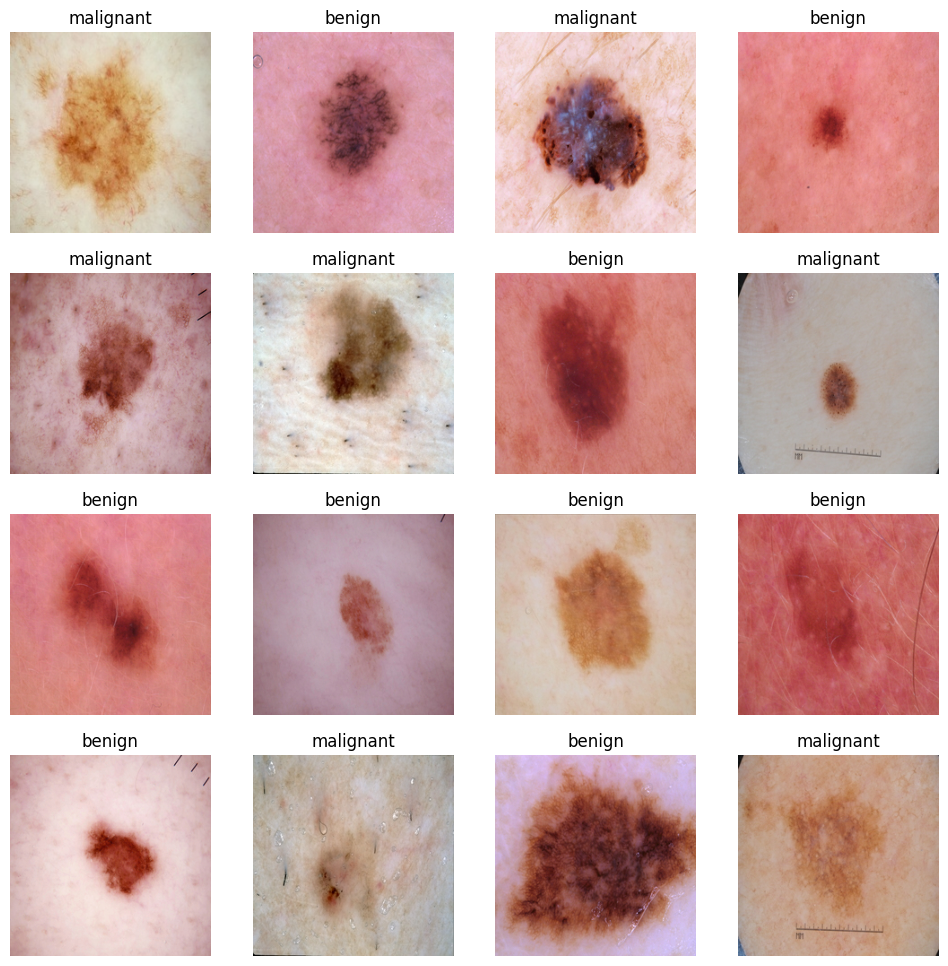

In [7]:
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE  # константа для оптимизации производительности
# распределитель ресурсов пк (потоки)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# кеширование -> перемешивание -> предварительная загрузка данных в память пк для обучения модели

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## Нормализация данных

In [9]:
normalization_layer = layers.Rescaling(1./255)
# делаем так, чтобы 1 - максимальное значение, а 0 - минимальное

0.050980397 1.0


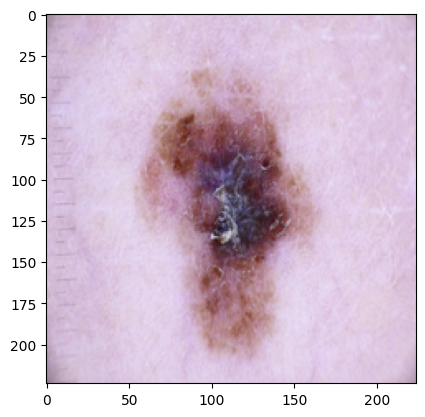

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in [0,1].
print(np.min(first_image), np.max(first_image))
plt.imshow(first_image);

`работа со слоями модели`

In [11]:
# типо Pipline

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),  # СВЕРТОЧНЫЙ СЛОЙ
  #  автоматически извлекает признаки из изображения, применяя операции двумерной свертки. 
  #Он выделяет абстракции и структуры в изображении: грани, текстуры и объекты - хвосты, глаза, полосы
  # 16 - batch_size (количество нейронов в слое); 3 - количество сгибов ; padding - добавление нулевых значений вокруг входных данных (same/valid)
  # same - на выходе размер матрицы сохраняется
  # valid - на выхоже размер матрицы не сохраняется
  layers.MaxPooling2D(),  # СУБДИСКРЕТЕЗИРУЮЩИЙ СЛОЙ
  # размножает картинку до n картинок и выделяет на каждой свои признаки (n - количество найденных признаков)
  layers.Conv2D(32, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),  # векторизует данные (разворачивает в строчку)
  layers.Dense(128, activation='relu'),  # применяет найденные весы к изначальному входному слою
  layers.Dense(num_classes)  # приводит к конечному результату (2 нейрона) (либо доброкачественная, либо злокачественная)
])

In [12]:
# компидяция модели

model.compile(optimizer='adam',  # тот, кто оптимизирует и считает модель
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # тот, кто считает потери и говорит, насколько модель права или нет
              metrics=['accuracy'])  # метод проверки на верность предсказания

In [13]:
model.summary()  # краткий свод по проделанной работе с моделью

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        1

## Обучение модели

In [14]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10


83/83 [==============================] - 16s 187ms/step - loss: 0.6713 - accuracy: 0.6395 - val_loss: 0.4589 - val_accuracy: 0.7648
Epoch 2/10
74/83 [=========================>....] - ETA: 1s - loss: 0.4689 - accuracy: 0.7555

KeyboardInterrupt: 

## Проверка точности на графиках

In [23]:
def img_show(img, title='image', figsize=(12, 12), fontsize=12):
    plt.figure(figsize=figsize)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(title)
    plt.axis("off")
    plt.show()


def training_analyze(epochs: int, acc, loss, val_acc=None, val_loss=None,
                     figsize=(12, 12), fontsize=12):
    """Анализ результата тренировки"""
    epochs_range = range(1, epochs+1)

    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    if val_acc: plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xticks(epochs_range)
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy', fontsize=fontsize)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    if val_loss: plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xticks(epochs_range)
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss', fontsize=fontsize)

    plt.show()

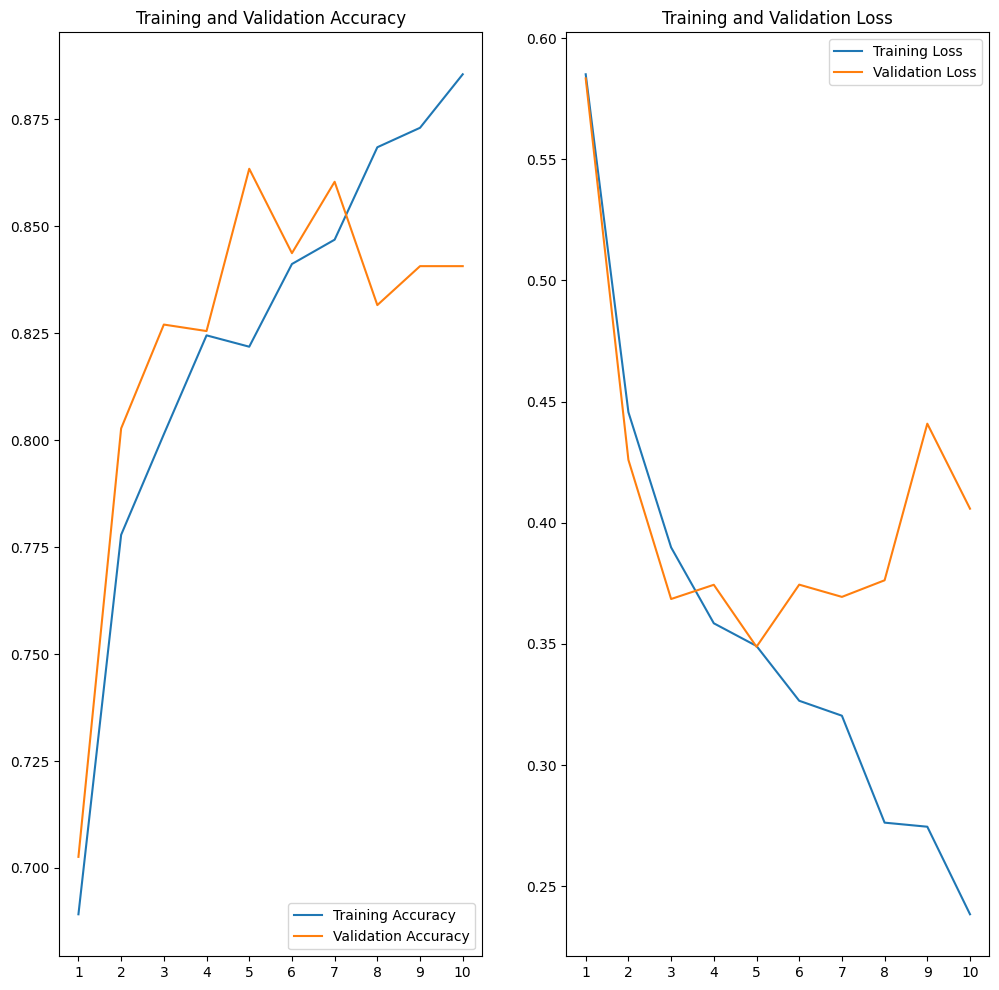

In [ ]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']

training_analyze(epochs, acc, loss, val_acc, val_loss)

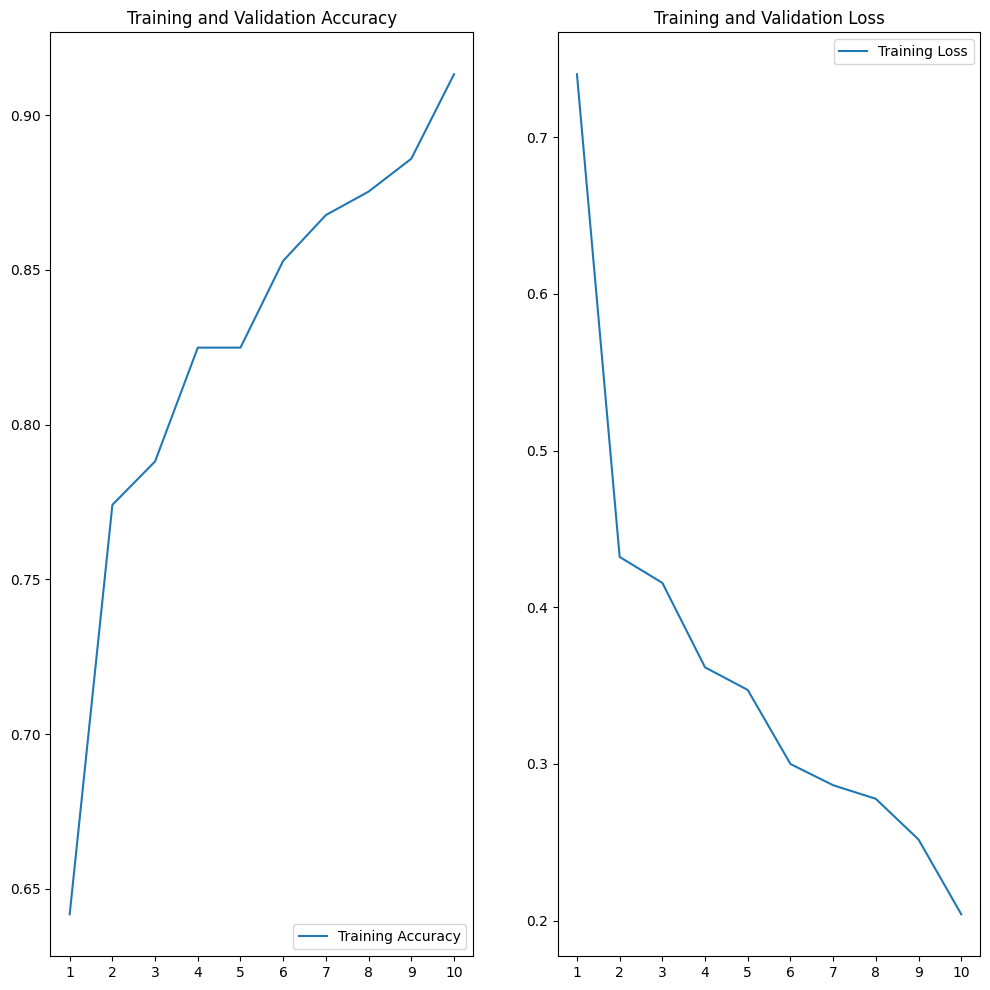

In [ ]:
acc, loss = history.history['accuracy'], history.history['loss']

training_analyze(epochs, acc, loss)

## Изменение исходного датасета путем разворотов изображений

In [15]:
data_augmentation = keras.Sequential(  # характеристика того, что надо сделать с изображениями
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

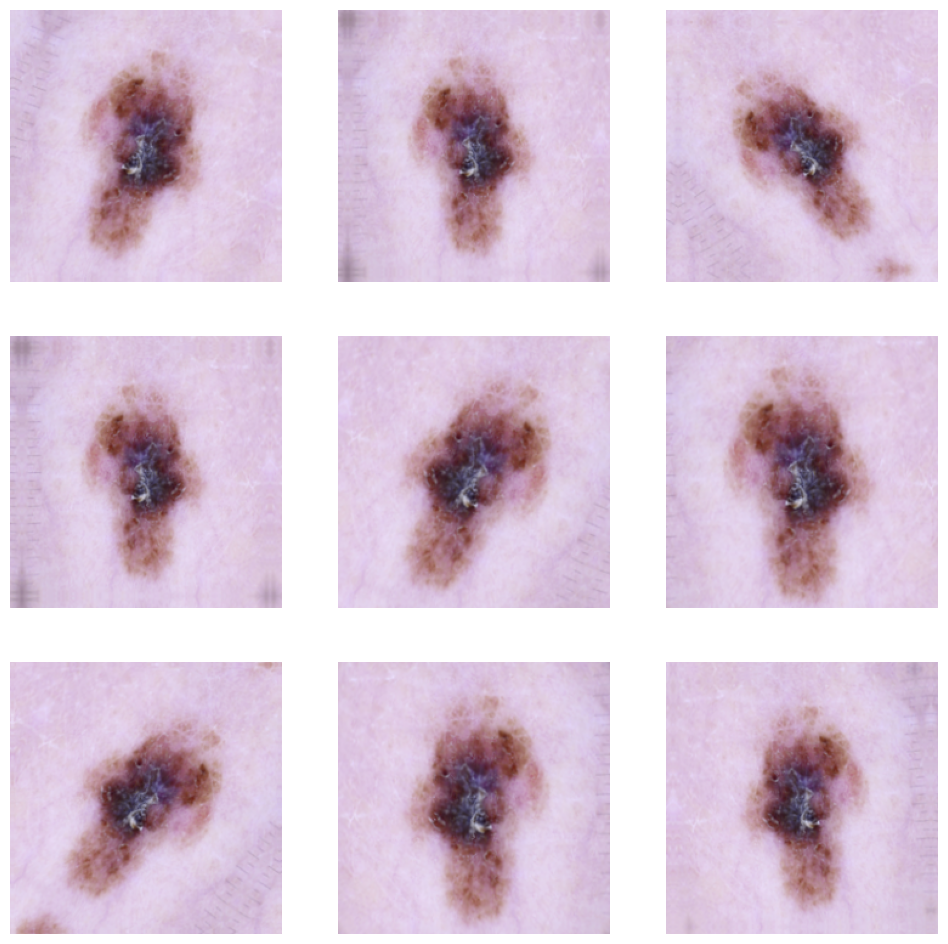

In [16]:
plt.figure(figsize=(12, 12))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [17]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),  # убираем лишние нейроны
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
model.compile(optimizer='adam',  # тот, кто оптимизирует и считает модель
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # тот, кто считает потери и говорит, насколько модель права или нет
              metrics=['accuracy'])  # метод проверки на верность предсказания

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                 

In [20]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=0, min_delta=0.01)]

In [21]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/15
83/83 [==============================] - 17s 195ms/step - loss: 0.6933 - accuracy: 0.6399 - val_loss: 0.5638 - val_accuracy: 0.7344
Epoch 2/15
83/83 [==============================] - 16s 191ms/step - loss: 0.4702 - accuracy: 0.7718 - val_loss: 0.4421 - val_accuracy: 0.7906
Epoch 3/15
83/83 [==============================] - 16s 191ms/step - loss: 0.4553 - accuracy: 0.7741 - val_loss: 0.4419 - val_accuracy: 0.7921
Epoch 4/15
83/83 [==============================] - 16s 191ms/step - loss: 0.4113 - accuracy: 0.7957 - val_loss: 0.4263 - val_accuracy: 0.7769
Epoch 5/15
83/83 [==============================] - 16s 191ms/step - loss: 0.4058 - accuracy: 0.7998 - val_loss: 0.3910 - val_accuracy: 0.8012
Epoch 6/15
83/83 [==============================] - 16s 191ms/step - loss: 0.3972 - accuracy: 0.8033 - val_loss: 0.3690 - val_accuracy: 0.8255
Epoch 7/15
83/83 [==============================] - 16s 191ms/step - loss: 0.3759 - accuracy: 0.8052 - val_loss: 0.3659 - val_accuracy: 0.8103

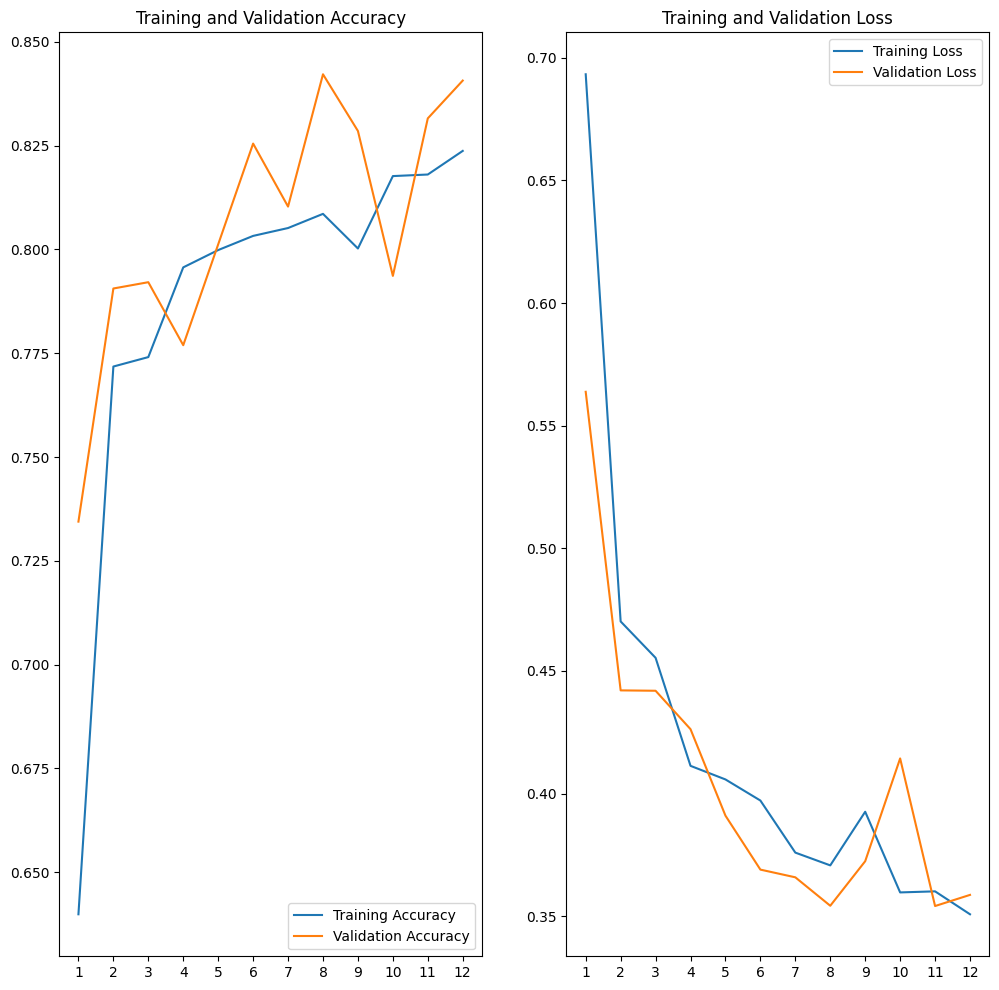

In [27]:
acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']

training_analyze(12, acc, loss, val_acc, val_loss)

## Оценка точности и потерь модели

In [25]:
res = model.evaluate(val_ds, batch_size=32)
print(f'loss: {res[0]}')
print(f'acc: {res[1]}')

 3/21 [===>..........................] - ETA: 0s - loss: 0.5288 - accuracy: 0.7812

21/21 [==============================] - 1s 40ms/step - loss: 0.3587 - accuracy: 0.8407
loss: 0.3586912155151367
acc: 0.8406676650047302


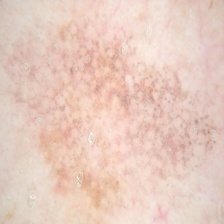

In [32]:
img = keras.utils.load_img('18.jpg')
img

In [ ]:
model.predict()

## Сохранение модели

In [ ]:
model_name = 'skin_canser'

model_name += '_(' + 'acc' + str(round(acc[-1] * 100, 2)) + '_loss' + str(round(loss[-1] *100, 2)) + ')_'
model_name += '.keras'
if model_name not in os.listdir(): model.save(model_name)

## Импорт модели

In [ ]:
model_name = 'skin_canser_(acc82.71_loss35.33)_.keras'

model = keras.models.load_model(model_name)

OSError: No file or directory found at skin_canser_(acc82.71_loss35.33)_.keras

## Предсказание модели

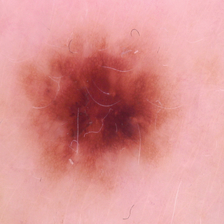

In [ ]:
img = tf.keras.utils.load_img(
    '357.jpg', 
    target_size=(img_height, img_width))
img

In [ ]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(f"Это изображение на {round(np.max(score) * 100, 2)} % похоже на {class_names[np.argmax(score)]}")

1/1 [==============================] - 0s 14ms/step
Это изображение на 99.05 % похоже на benign
